In [1]:
pwd = '../all_images/imagerl'
pwd_data = '../all_data/datarl'

In [2]:
import os
import sys
sys.path.append("../")
import json
import pickle
import random
from sim.sim_use import make_random_paire_list_instr
from exploration.history import History
from exploration.imgep.features import Features
import numpy as np
from exploration.env.func import Env
from  exploration.imgep.OptimizationPolicy import OptimizationPolicykNN
from exploration.imgep.intrinsic_reward import IR
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

/home/ludovic/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
import torch
import torch.nn as nn
from torch import distributions

In [4]:
num_bank = 4
num_addr = 20

In [5]:
En = Env(repetition=1,num_banks = num_bank,num_addr = num_addr)

In [6]:
output = En(make_random_paire_list_instr(50,num_addr=20))

In [7]:
output.keys()

dict_keys(['shared_cache_miss', 'miss_ratios', 'miss_ratios_global', 'miss_ratios_global0', 'miss_ratios_global1', 'miss_ratios_core0', 'miss_ratios_core1', 'time_core0_together', 'time_core1_together', 'time_core0_alone', 'time_core1_alone', 'miss_count', 'miss_count_core0', 'miss_count_core1', 'diff_ratios_core0', 'diff_ratios_core1', 'diff_time0', 'diff_time1', 'miss_ratios_detailled', 'miss_ratios_core0_detailled', 'miss_ratios_core1_detailled', 'core1_L1_cache_miss', 'core1_L2_cache_miss', 'core1_L3_cache_miss', 'core0_L1_cache_miss', 'core0_L2_cache_miss', 'core0_L3_cache_miss'])

In [8]:
pp = ['shared_cache_miss', 
      #'miss_ratios',
      #'miss_ratios_global', 
      #'miss_ratios_global0',
      #'miss_ratios_global1', 
      #'miss_ratios_core0', 
      #'miss_ratios_core1', 
      'time_core0_together', 
      'time_core1_together', 
      'time_core0_alone', 
      'time_core1_alone',
      #'miss_count',
      #'miss_count_core0',
      #'miss_count_core1',
      'diff_ratios_core0',
      'diff_ratios_core1',
      'diff_time0',
      'diff_time1',
      'miss_ratios_detailled',
      'miss_ratios_core0_detailled',
      'miss_ratios_core1_detailled',
      #'core1_L1_cache_miss',
      #'core1_L2_cache_miss',
      #'core1_L3_cache_miss',
      #'core0_L1_cache_miss',
      #'core0_L2_cache_miss',
      #'core0_L3_cache_miss'
     ]

In [9]:
def env_observation2_subset(output):
    out_list = []
    for o in pp:
            #print(j,o,output[o])
            out_list.append(np.array(output[o]).flatten())
    return np.concatenate(out_list)

In [10]:
out_list = env_observation2_subset(output)

In [11]:
out_list

array([-1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  1., -1., 77., 69., 78., 69.,  0.,  1.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.])

In [12]:
class GoalGenerator(Features):
    def __init__(self,
                 num_bank:int,
                 modules:list,
                 H:History,
                 pi:OptimizationPolicykNN
                 ):
        #super().__init__()
        Features.__init__(self)
        self.num_bank = num_bank
        self.k_time = 0
        self.k_miss = 0
        self.modules = modules
        self.history = H
        self.pi = pi
        
    def rand(self,stat)->np.ndarray:
        min_ = stat.min(axis=-1)
        max_ = stat.max(axis=-1)
        out = np.random.uniform((1-np.sign(min_)*0.6)*min_,4.0*max_)
        return out
    def diversity_representation(self,module:dict):
        feature = self.data2feature(self.history.memory_perf,module)
        hist,_ = np.histogram(feature,bins=module["bins"])
        return hist
    def __call__(self,H:History, module:str)->np.ndarray:
        assert module in self.modules, f"module {module} unknown"
        stat = self.diversity_representation(module)
        out = self.rand(stat)
        return out

In [13]:
class IMGEP_:
    """
    N: int. The experimental budget
    N_init: int. Number of experiments at random
    H: History. Buffer containing codes and signature pairs
    G: GoalGenerator.
    Pi: OptimizationPolicy.
    """
    def __init__(self,
                 N:int,
                 N_init:int,
                 E:Env,
                 H:History,
                 G:GoalGenerator, 
                 Pi:OptimizationPolicykNN,
                 ir:IR,
                 modules:list[dict],
                 periode:int = 1,
                 max_len:int = 100):
        self.N = N
        self.env = E
        self.H = H
        self.G = G
        self.N_init = N_init
        self.Pi = Pi
        self.ir = ir
        self.periode = periode
        self.modules = modules 
        self.max_len = max_len
        self.start = 0
        self.periode_expl = 10
        self.k = 0
    def take(self,sample:dict,N_init:int): 
        """Takes the ``N_init`` first steps from the ``sample`` dictionnary to initialize the exploration. 
        Then the iterator i is set to N_init directly
        """
        print("sampl", sample.keys())
        for key in sample["memory_perf"].keys():
            self.H.memory_perf[key]= list(sample["memory_perf"][key][:N_init])
        self.H.memory_program["core0"] = sample["memory_program"]["core0"][:N_init]
        self.H.memory_program["core1"] = sample["memory_program"]["core1"][:N_init]
        self.start = N_init

In [14]:
class IMGEP(IMGEP_):
    def __init__(self,
                 N:int,
                 N_init:int,
                 E:Env,
                 H:History,
                 G:GoalGenerator, 
                 Pi:OptimizationPolicykNN,
                 ir:IR,
                 modules:list[dict],
                 periode:int = 1,
                 max_len:int = 100):
        super(IMGEP,self).__init__(N,N_init, En,H,G,Pi,ir=ir, modules = modules, periode = periode, max_len = max_len)
    def __call__(self,intr_reward=True):
        
        """Performs the exploration.
        intr_reward:bool. If True, the exploration uses intrinsic reward based on diversity
        """
        time_explor = 0
        for i in range(self.start,self.N+1):
            if i%100==0:
                print(f"{i} iterations")
            if i<time_explor:
                continue
            if i<=self.N_init:
                parameter = make_random_paire_list_instr(self.max_len,num_addr=self.env.num_addr)
            else:
                if intr_reward:
                    #Sample target goal
                    if (i-self.N_init)%(self.periode_expl*self.periode)==0:
                        self.ir(self.N)
                        time_explor = i + self.ir.num_iteration*len(self.ir.modules)
                        print("time explor", time_explor)
                        module = self.ir.choice()
                        goal = self.G(self.H, module = module)
                        print("i",i,"module type",module["type"],"diversity",module["diversity"])
                        print("probs", self.ir.prob())
                        continue
                    elif (i-self.N_init)%self.periode==0:
                        module = self.ir.choice()
                        goal = self.G(self.H, module = module)
                else:
                    if (i-self.N_init)%self.periode==0 and i>self.N_init:
                        module = random.choice(self.modules)
                    if (i-self.N_init)>1:
                        previous_module = module
                    goal = self.G(self.H, module = module)
                parameter = self.Pi(goal,self.H, module)
            observation = self.env(parameter)
            self.H.store({"program":parameter}|observation)
            self.H.memory_tab.append(env_observation2_subset(observation))

In [15]:
periode  =5
max_len = 50
num_banks = 4
num_addr = 20
mutation_rate = 0.1


In [16]:
periode = 20
mutation_rate = 0.1
#N = config_data["N"]
#N_init = config_data["N_init"]

max_len = 50
min_len=5
#min_len = config_data["min_len"]
#folder = config_data["folder"]
num_iteration = 5

In [17]:
N = 100
N_init = 100

In [18]:
H = History(N)

In [19]:
k =2
Pi = OptimizationPolicykNN(k=k,mutation_rate=mutation_rate,max_len=max_len,num_addr=num_addr,num_bank=num_bank,min_instr=min_len,max_instr=max_len)

In [20]:
G = GoalGenerator(num_bank,None,H,Pi)

In [21]:
imgep = IMGEP(N,N_init, En,H,None,Pi,ir=None, modules = None, periode = periode, max_len = max_len)

In [22]:
imgep.take(H.content(),0)

sampl dict_keys(['memory_perf', 'memory_program'])


In [23]:
imgep(intr_reward=False)

0 iterations
100 iterations


In [27]:
np.array(H.memory_tab).shape

(101, 58)

In [33]:
class ae(nn.Module):
    def __init__(self,size):
        nn.Module.__init__(self)
        self.size = size
        self.linear1 = nn.Linear(size,64)
        self.linear2 = nn.Linear(64,32)
        self.linear3 = nn.Linear(32,16)
        self.linear4 = nn.Linear(16,8)
        
        
    def encoder(self,x):
        out = self.linear1(x)
        
        return out
    def decoder(self,x):
        out = self.linear1(x)
        
    def forward(self,x):


In [34]:
aa = ae(58)

In [35]:
in_ = torch.Tensor(np.array(H.memory_tab))

In [36]:
aa(in_)

tensor([[-1.0027e+01,  1.3279e+01,  1.2370e+01,  1.5949e+01, -1.3252e+01],
        [-7.7764e+00,  1.1132e+01,  1.1777e+01,  1.3185e+01, -1.1647e+01],
        [-9.0622e+00,  1.2823e+01,  1.0977e+01,  1.3188e+01, -1.4478e+01],
        [-1.2377e+01,  1.2214e+01,  2.9329e+01,  2.3136e+01, -1.6240e+01],
        [-1.5784e+01,  1.7776e+01,  1.5727e+01,  1.9661e+01, -1.5654e+01],
        [-7.5473e+00,  5.0406e+00,  2.5376e+01,  1.2401e+01, -2.8660e+01],
        [-7.7133e+00,  1.0067e+01,  1.5223e+01,  1.5379e+01, -1.0661e+01],
        [-7.2397e+00,  1.0433e+01,  1.3502e+01,  1.4223e+01, -7.0422e+00],
        [-1.5303e+01,  1.8920e+01,  3.9223e+01,  3.7552e+01,  4.1657e+00],
        [-2.0165e+01,  1.5665e+01,  1.7514e+01,  2.2313e+01, -1.1679e+00],
        [-2.1075e+01,  2.3255e+01,  2.3783e+01,  2.8763e+01, -1.5361e+01],
        [-8.2574e+00,  1.1003e+01,  1.4502e+01,  1.5295e+01, -6.6807e+00],
        [-8.1404e+00,  1.1173e+01,  1.4325e+01,  1.5836e+01, -7.0820e+00],
        [-1.9536e+01,  1.

In [27]:
import matplotlib.pyplot as plt

In [28]:
bank = 3
row = 1

In [29]:
print(ratios_type[0]["type"])
feature = F.data2feature(H.memory_perf,ratios_type[0])
print(feature)

NameError: name 'ratios_type' is not defined

In [30]:
p = Pi.select_closest_codes(H,.0,ratios_type[0])

NameError: name 'ratios_type' is not defined

In [ ]:
print(len(p["program"]["core0"][0]))
print(len(p["program"]["core1"][0]))

In [ ]:
len(H)

In [ ]:
print(len(H.memory_program["core0"][0])==len(H.memory_program["core1"][0]))

In [ ]:
len(H.memory_program["core0"][4])

In [ ]:
print(p["program"]["core1"][1])

In [72]:
content = H.content()["memory_perf"]

In [90]:
row =1
bank = 1

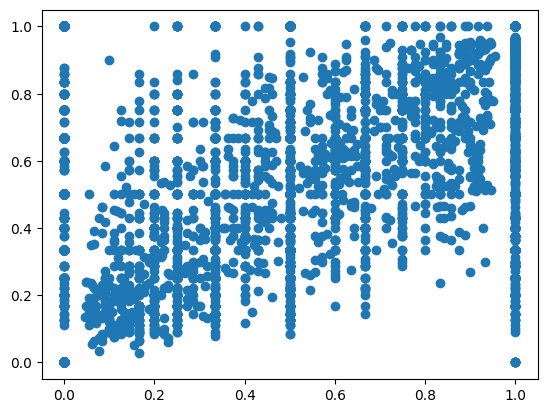

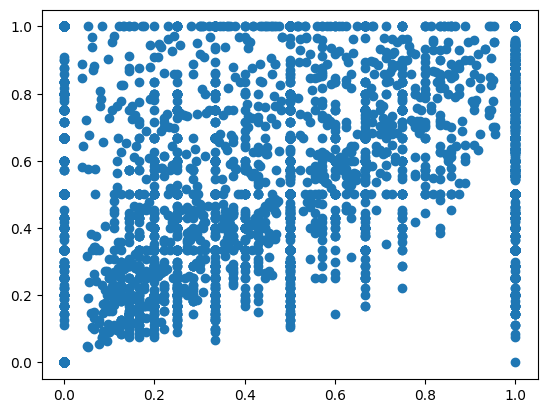

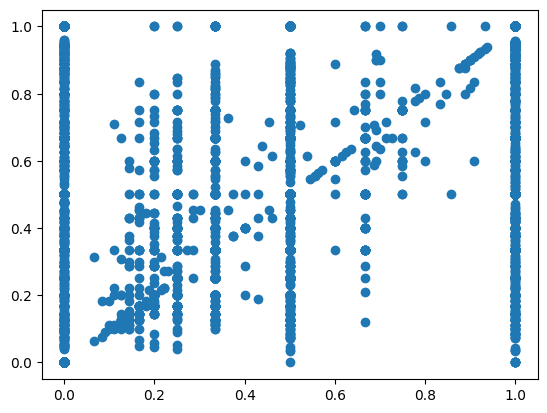

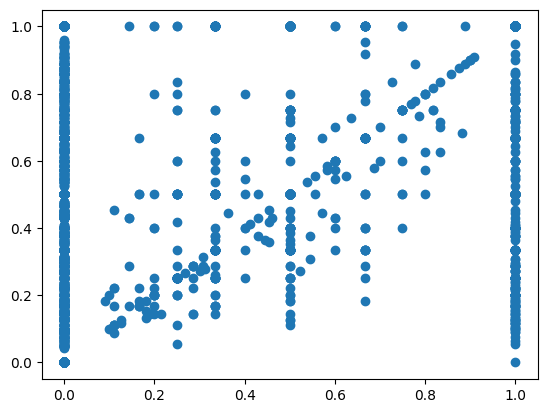

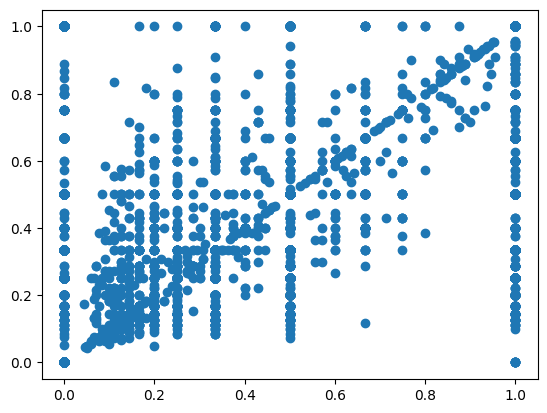

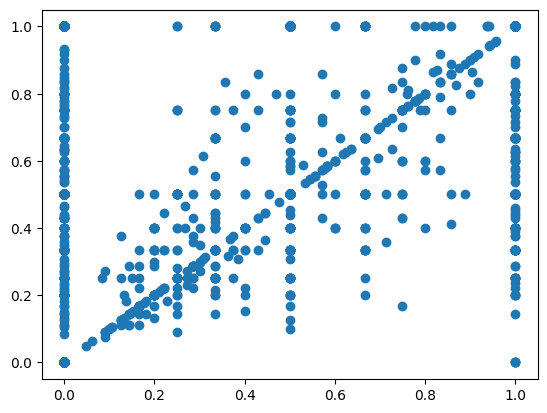

In [267]:
for bank in range(3):
    for row in range(2):
        plt.figure()
        plt.scatter(content["miss_ratios_core1_detailled"][:,row,bank],content["miss_ratios_detailled"][:,row,bank])

In [97]:
for module in ratios_type:
    print("type",module["type"],np.sum(G.diversity_representation(module)>0))

type miss_ratios 77
type miss_ratios 81
type miss_ratios 74
type miss_ratios 77
type miss_ratios 63
type miss_ratios 66
type miss_ratios 60
type miss_ratios 54
type miss_ratios 52
type miss_ratios 72
type miss_ratios 45
type miss_ratios 57
type miss_ratios_detailled 51
type miss_ratios_detailled 54
type miss_ratios_detailled 61
type miss_ratios_detailled 53
type miss_ratios_detailled 43
type miss_ratios_detailled 39
type miss_ratios_detailled 48
type miss_ratios_detailled 46
type miss_ratios_detailled 33
type miss_ratios_detailled 39
type miss_ratios_detailled 35
type miss_ratios_detailled 41
type miss_ratios_detailled 26
type miss_ratios_detailled 33
type miss_ratios_detailled 37
type miss_ratios_detailled 29
type miss_ratios_detailled 27
type miss_ratios_detailled 29
type miss_ratios_detailled 50
type miss_ratios_detailled 38
type miss_ratios_detailled 26
type miss_ratios_detailled 24
type miss_ratios_detailled 33
type miss_ratios_detailled 33


In [74]:
from visu2 import comparaison3

In [75]:
len(H)

10001

In [76]:
content = H.content()["memory_perf"]

In [77]:
content_n = H_n.content()["memory_perf"]

In [78]:
content.keys()==content_random.keys()

False

In [80]:
content_random.keys()

dict_keys(['miss_ratios', 'miss_ratios_global', 'miss_ratios_global0', 'miss_ratios_global1', 'miss_ratios_core0', 'miss_ratios_core1', 'time_core0_together', 'time_core1_together', 'time_core0_alone', 'time_core1_alone', 'miss_count', 'miss_count_core0', 'miss_count_core1', 'diff_ratios_core0', 'diff_ratios_core1', 'diff_time0', 'diff_time1', 'miss_ratios_detailled', 'miss_ratios_core0_detailled', 'miss_ratios_core1_detailled'])

In [79]:
content.keys()

dict_keys(['miss_ratios', 'miss_ratios_global', 'miss_ratios_global0', 'miss_ratios_global1', 'miss_ratios_core0', 'miss_ratios_core1', 'time_core0_together', 'time_core1_together', 'time_core0_alone', 'time_core1_alone', 'miss_count', 'miss_count_core0', 'miss_count_core1', 'diff_ratios_core0', 'diff_ratios_core1', 'diff_time0', 'diff_time1', 'miss_ratios_detailled', 'miss_ratios_core0_detailled', 'miss_ratios_core1_detailled', 'shared_cache_miss', 'core1_L1_cache_miss', 'core1_L2_cache_miss', 'core1_L3_cache_miss', 'core0_L1_cache_miss', 'core0_L2_cache_miss', 'core0_L3_cache_miss'])

In [81]:
comparaison3(content_random,content,["2Dplotmissratios","time"],"miss ratios")

In [291]:
comparaison3(content_random,content_n,["2Dplotmissratios_n","time_n"],"miss ratios")

In [284]:
content

{'miss_ratios': array([[0.75      , 1.        , 1.        , 0.5       ],
        [0.75      , 0.5       , 0.5       , 0.5       ],
        [0.66666667, 0.        , 1.        , 0.4       ],
        ...,
        [0.66666667, 0.5       , 0.25      , 0.2       ],
        [0.6       , 0.6       , 0.75      , 0.375     ],
        [0.125     , 0.66666667, 1.        , 0.5       ]]),
 'miss_ratios_global': array([0.75      , 0.58333333, 0.55555556, ..., 0.41176471, 0.55555556,
        0.4       ]),
 'miss_ratios_global0': array([0.8       , 0.55555556, 0.5       , ..., 0.85714286, 0.53846154,
        0.44444444]),
 'miss_ratios_global1': array([0.66666667, 1.        , 1.        , ..., 0.5       , 0.91666667,
        0.57142857]),
 'miss_ratios_core0': array([[1.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.5       , 0.5       , 1.        ],
        [1.        , 0.        , 1.        , 0.25      ],
        ...,
        [1.        , 1.        , 0.5       , 0.        ],
   

In [289]:
len(H_n)

10000

In [ ]:
compa